In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings("ignore")

import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Describe Dataset

Sign languages (also known as signed languages) are languages that use manual communication to convey meaning. This can include simultaneously employing hand gestures, movement, orientation of the fingers, arms or body, and facial expressions to convey a speaker's ideas.
Source: https://en.wikipedia.org/wiki/Sign_language

**Details of datasets:**

* Image size: 64x64
* Color space: Grayscale
* File format: npy
* Number of classes: 10 (Digits: 0-9)
* Number of participant students: 218
* Number of samples per student: 10

Load images:

In [2]:
X = np.load("../input/sign-language-digits-dataset/X.npy")
y = np.load("../input/sign-language-digits-dataset/Y.npy")

print(X.shape)
print(y.shape)

(2062, 64, 64)
(2062, 10)


The labels in the dataset are **not the actual number** being displayed in the image, but let's take a look at a sample of images and their labels:

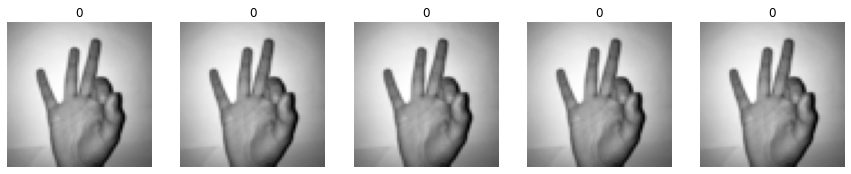

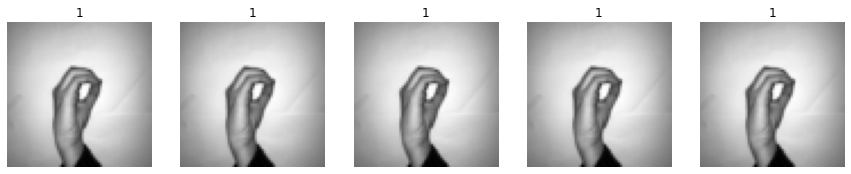

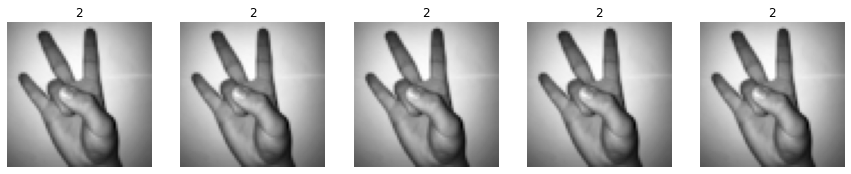

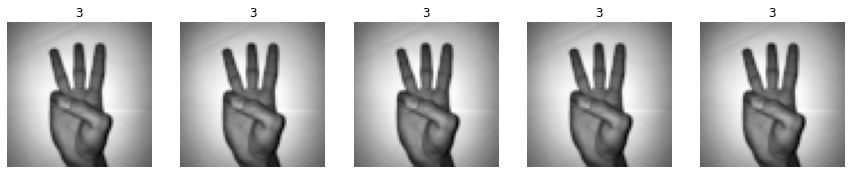

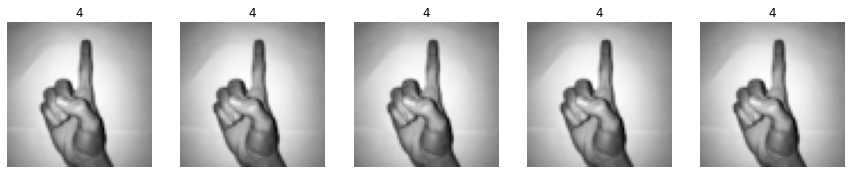

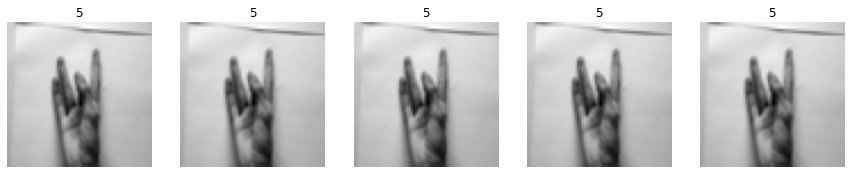

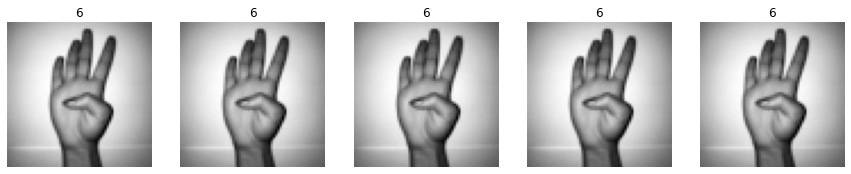

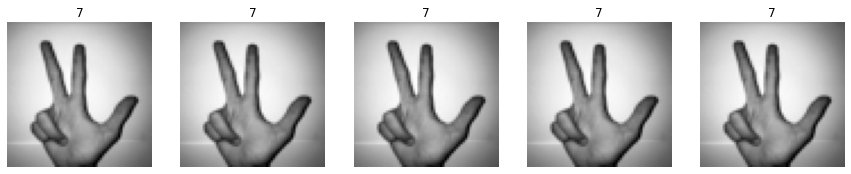

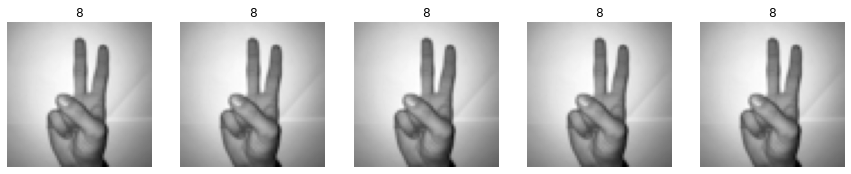

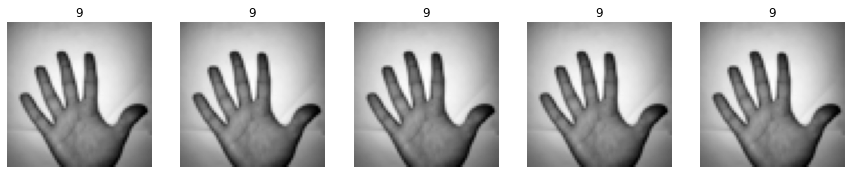

In [3]:
for number, i in zip(range(11), range(100, 2000, 200)):
    fig, axes = plt.subplots(1, 5, figsize=(15, 12))
    for ax in axes:
        ax.imshow(X[i].reshape(64, 64), cmap="gray")
        ax.set_title(number)
        ax.axis("off")
    plt.show()

The actual mapping is:
* Number 0 - Label 1
* Number 1 - Label 4
* Number 2 - Label 8
* Number 3 - Label 7
* Number 4 - Label 6
* Number 5 - Label 9
* Number 6 - Label 3
* Number 7 - Label 2
* Number 8 - Label 5
* Number 9 - Label 0

In [4]:
label_to_digit = {
    1: 0,
    4: 1,
    8: 2,
    7: 3,
    6: 4,
    9: 5,
    3: 6,
    2: 7,
    5: 8,
    0: 9,
}

These are the actual digits displayed in the images:

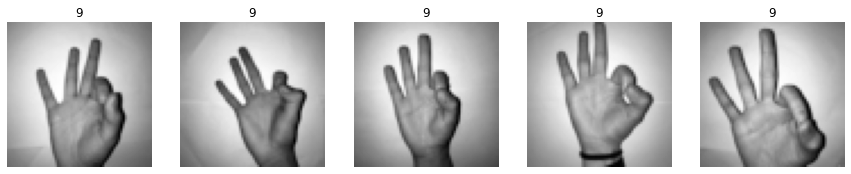

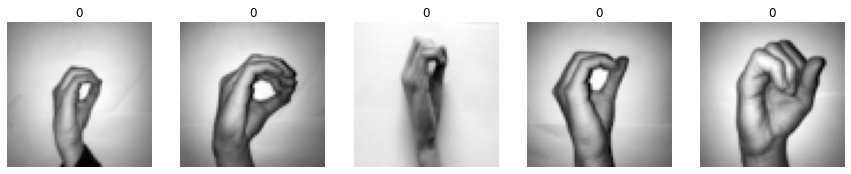

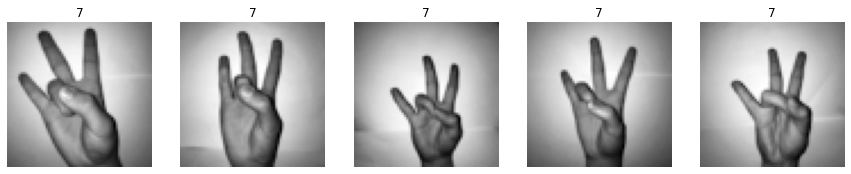

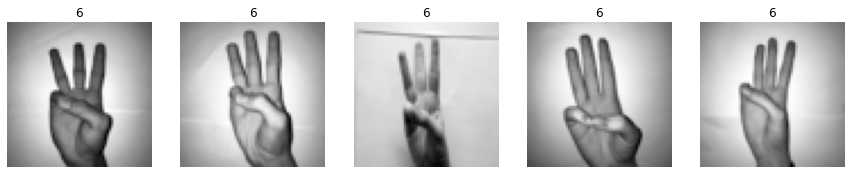

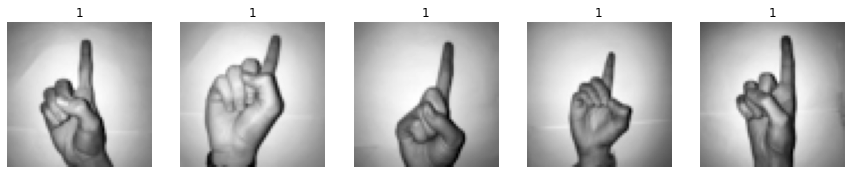

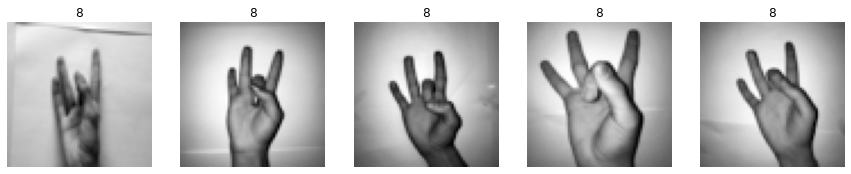

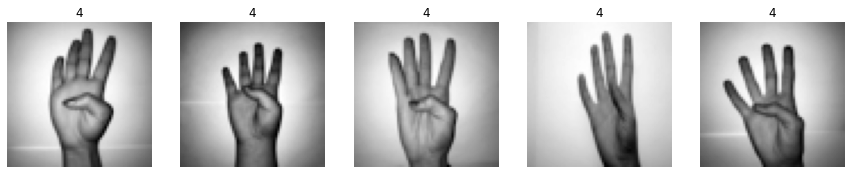

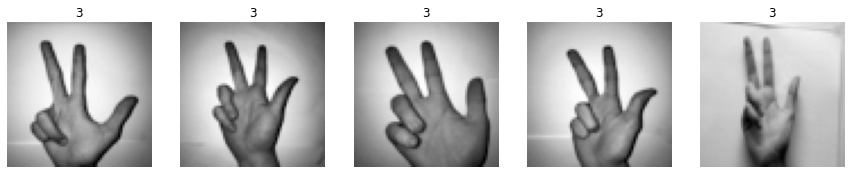

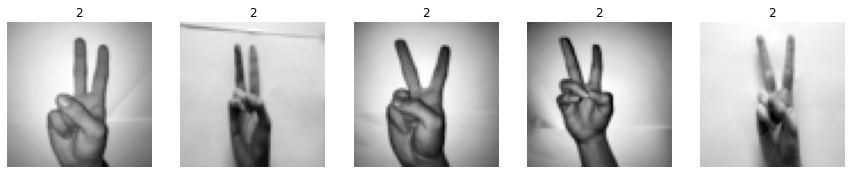

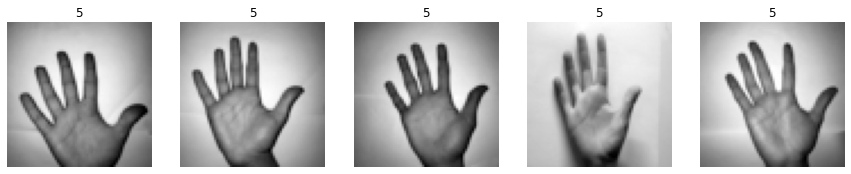

In [5]:
for label, i in zip(range(0, 10), range(100, 2000, 200)):
    fig, axes = plt.subplots(1, 5, figsize=(15, 12))
    for j, ax in enumerate(axes):
        ax.imshow(X[i + j].reshape(64, 64), cmap="gray")
        digit = label_to_digit[label]
        ax.set_title(digit)
        ax.axis("off")
    plt.show()

Text(0.5, 1.0, 'Destribution of digits in sign language dataset')

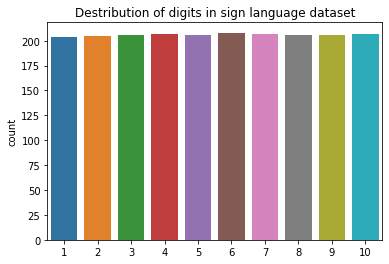

In [6]:
indexes = [res.tolist().index(1.) + 1 for res in y]
sns.countplot(x=indexes).set_title("Destribution of digits in sign language dataset")

# Classify Images to Numbers (CNN)

## Train/Test Split (80/20)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=100, shuffle=True)

x_train= X_train.reshape(-1,64,64,1)
x_test= X_test.reshape(-1,64,64,1)

print("x_train", x_train.shape)
print("x_test", x_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)

x_train (1649, 64, 64, 1)
x_test (413, 64, 64, 1)
y_train (1649, 10)
y_test (413, 10)


## CNN Architecture

In [8]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(64, 64, 1)),
    keras.layers.Conv2D(32, kernel_size=3, activation="relu", strides=1, padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='same'),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(64, kernel_size=3, activation="relu", padding='same', strides=1),
    keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='same'),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(128, kernel_size=3, activation="relu", padding='same', strides=1),
    keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='same'),
    keras.layers.Dropout(0.2),

    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation="softmax"),
])
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       7

2022-04-02 15:48:44.083811: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Data Augmentation

I performed the following data augmentation operations:
1. Randomly rotate images in the range 5 degrees
2. Randomly zoom image by 20%
3. Randomly shift images horizontally by 10%
4. Randomly shift images vertically 10%

In [9]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
)

datagen.fit(x_train)

## Train Model

In [10]:
epochs=50
batch_size=32
validation_size = int(len(y_train) * 0.1)

history = model.fit_generator(datagen.flow(x_train[validation_size:] ,y_train[validation_size:], batch_size=batch_size),
                              validation_data = (x_train[:validation_size],y_train[:validation_size]),
                              epochs = epochs)

2022-04-02 15:48:45.078957: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
47/47 [==============================] - 7s 123ms/step - loss: 2.3124 - accuracy: 0.0990 - val_loss: 2.3031 - val_accuracy: 0.1098
Epoch 2/50
47/47 [==============================] - 5s 115ms/step - loss: 2.3027 - accuracy: 0.0923 - val_loss: 2.3037 - val_accuracy: 0.0732
Epoch 3/50
47/47 [==============================] - 5s 114ms/step - loss: 2.3013 - accuracy: 0.1172 - val_loss: 2.3008 - val_accuracy: 0.0610
Epoch 4/50
47/47 [==============================] - 5s 116ms/step - loss: 2.2766 - accuracy: 0.1354 - val_loss: 2.0902 - val_accuracy: 0.3659
Epoch 5/50
47/47 [==============================] - 5s 114ms/step - loss: 1.8396 - accuracy: 0.3481 - val_loss: 1.3604 - val_accuracy: 0.6098
Epoch 6/50
47/47 [==============================] - 5s 112ms/step - loss: 1.4741 - accuracy: 0.5024 - val_loss: 1.2174 - val_accuracy: 0.6220
Epoch 7/50
47/47 [==============================] - 5s 116ms/step - loss: 1.2646 - accuracy: 0.5657 - val_loss: 0.8402 - val_accuracy: 0.7927
Epoch 

# Results & Evaluation

## Visualize Training Process

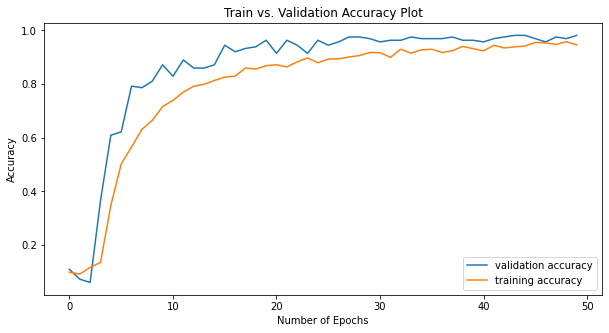

In [11]:
plt.figure(figsize = (10,5))
plt.plot(history.history['val_accuracy'], label="validation accuracy")
plt.plot(history.history['accuracy'], label="training accuracy")
plt.title("Train vs. Validation Accuracy Plot")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

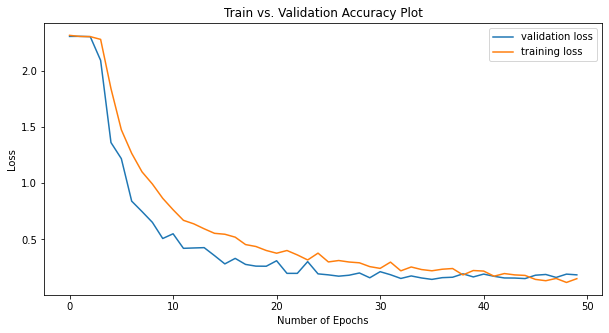

In [12]:
plt.figure(figsize = (10,5))
plt.plot(history.history['val_loss'], label="validation loss")
plt.plot(history.history['loss'], label="training loss")
plt.title("Train vs. Validation Accuracy Plot")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Model Classification Performance

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Train Accuracy
y_predict = [res.tolist().index(max(res)) for res in model.predict(x_train)]
y_train = [res.tolist().index(1.) for res in y_train]
print(f"Train Accuracy: {accuracy_score(y_train, y_predict)}")

# Test Accuracy
y_predict = [res.tolist().index(max(res)) for res in model.predict(x_test)]
y_test = [res.tolist().index(1.) for res in y_test]
print(f"Test Accuracy: {accuracy_score(y_test, y_predict)}")


Train Accuracy: 0.9945421467556095
Test Accuracy: 0.9782082324455206


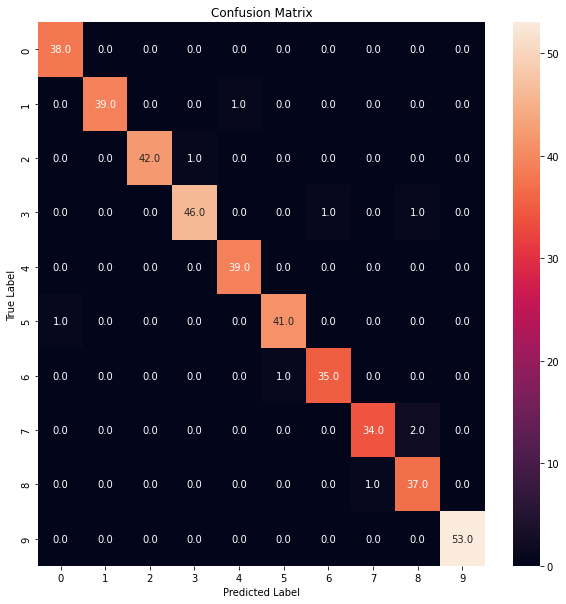

In [14]:
confusion_mtx = confusion_matrix(y_test, y_predict) 
plt.figure(figsize = (10,10))
sns.heatmap(confusion_mtx, annot=True,fmt= '.1f')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Examine Misclassified Data

Total of 9 images:

Image #32
Classified: 6
Actual: 7


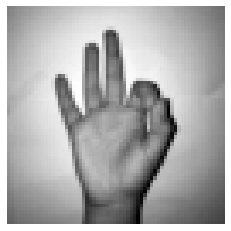



Image #131
Classified: 3
Actual: 2


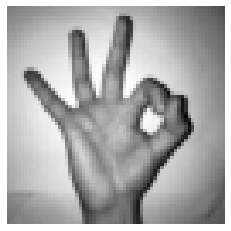



Image #186
Classified: 2
Actual: 3


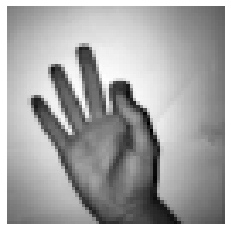



Image #215
Classified: 8
Actual: 4


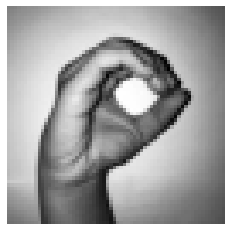



Image #261
Classified: 4
Actual: 6


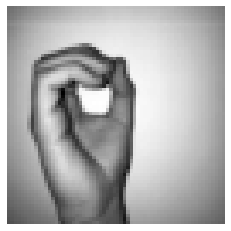



Image #271
Classified: 2
Actual: 6


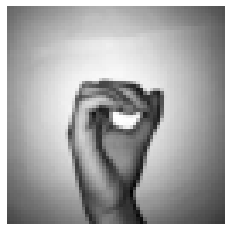



Image #373
Classified: 1
Actual: 0


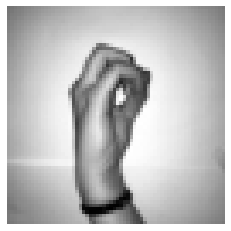



Image #378
Classified: 2
Actual: 3


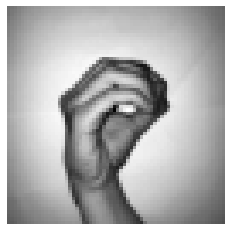



Image #403
Classified: 9
Actual: 8


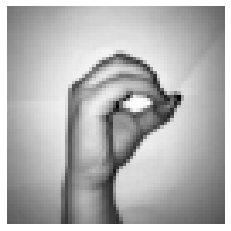

In [15]:
misclassified = [i for i, (expected, actual) in enumerate(zip(y_test, y_predict)) if expected != actual]

print(f"Total of {len(misclassified)} images:\n")
for i in misclassified:
    print(f"Image #{i}")
    print(f"Classified: {label_to_digit[y_predict[i]]}")
    print(f"Actual: {label_to_digit[y_test[i]]}")
    plt.imshow(X[i + j].reshape(64, 64), cmap="gray")
    plt.axis("off")
    plt.show()
    print("\n")

By looking at the misclassified images, one can notice that **almost all these images have wrong label in the dataset**.
* **Images 90, 131, 186**: display number 9, but are labeled each with different labels. The model managed to identify number 90 correctly, but classified the other two images wrong.
* **Images 241, 373, 378, 403**: display the number 0, while the last 3 are labeled with incorrect labels. The model misclassiffied all 3.

# Conclusion

As mentioned, some of the images in the dataset turned out to be labeled wrong. I noticed 6 such images which the model misclassified, but there might be more such images. Such inaccuracies may lead to a model whose accuracy on the task may not be as high as one can expect.
Overall the the trained model is highly accurate 98% accuracy rates on the test set.